# Steps going to be followed

* Import the os, numpy, pandas, matplotlib, seaborn, tensorflow and sklearn libraries
* Load the data from the csv file
* Data path connection
* Data resizing
* Build CNN model

[Get the dataset here](https://www.kaggle.com/datasets/arpitjain007/game-of-deep-learning-ship-datasets)

# Import the libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler


### Connect the paths and read the data

In [2]:
path = os.getcwd() + "\\train"
train = pd.read_csv(path + "\\train.csv")
train.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [3]:
train.shape

(6252, 2)

In [4]:
train_categories = {1 : 'Cargo',
2 : 'Military',
3 : 'Carrier',
4 : 'Cruise',
5 : 'Tankers'}

### Visualize the data balance

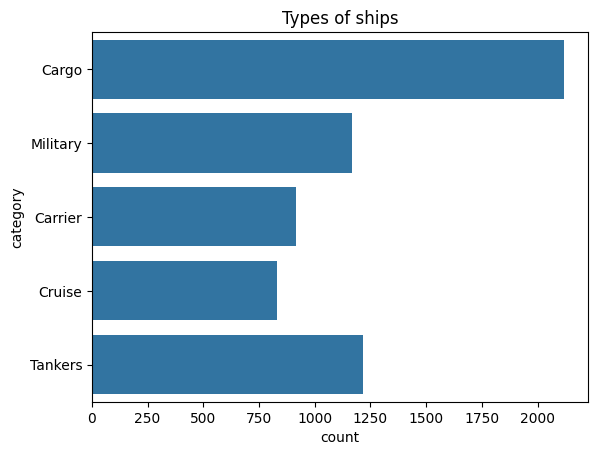

In [5]:
sns.countplot(data=train["category"].map(train_categories))
plt.title("Types of ships")
plt.show()

In [6]:
ros = RandomOverSampler(random_state=42)
y = train[["category"]]
x = train.drop(columns="category")
one, two = ros.fit_resample(x, y)
train = pd.concat([one, two], axis=1)

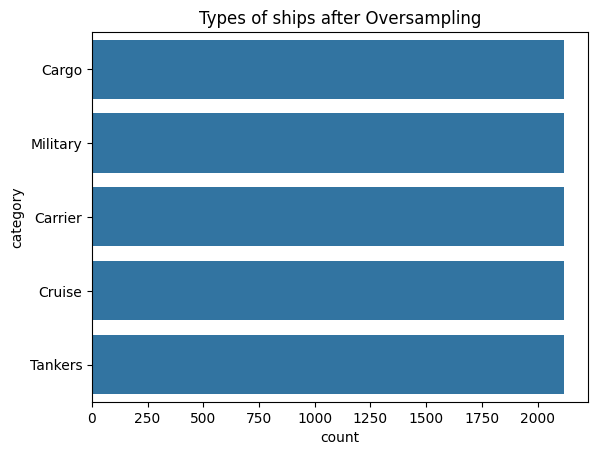

In [7]:
sns.countplot(data=train["category"].map(train_categories))
plt.title("Types of ships after Oversampling")
plt.show()

#### Data resizing

In [8]:
target_size = (128, 128)
resized_images = []
paths = []
for image in train["image"]:
    img_path = path + f"\\images\\{image}"
    img = tf.keras.utils.load_img(img_path, target_size=target_size)
    img = tf.image.convert_image_dtype(img, tf.float16)
    img = tf.keras.utils.img_to_array(img)
    resized_images.append(img)
    paths.append(img_path)

In [9]:
resized_images = np.asarray(resized_images)

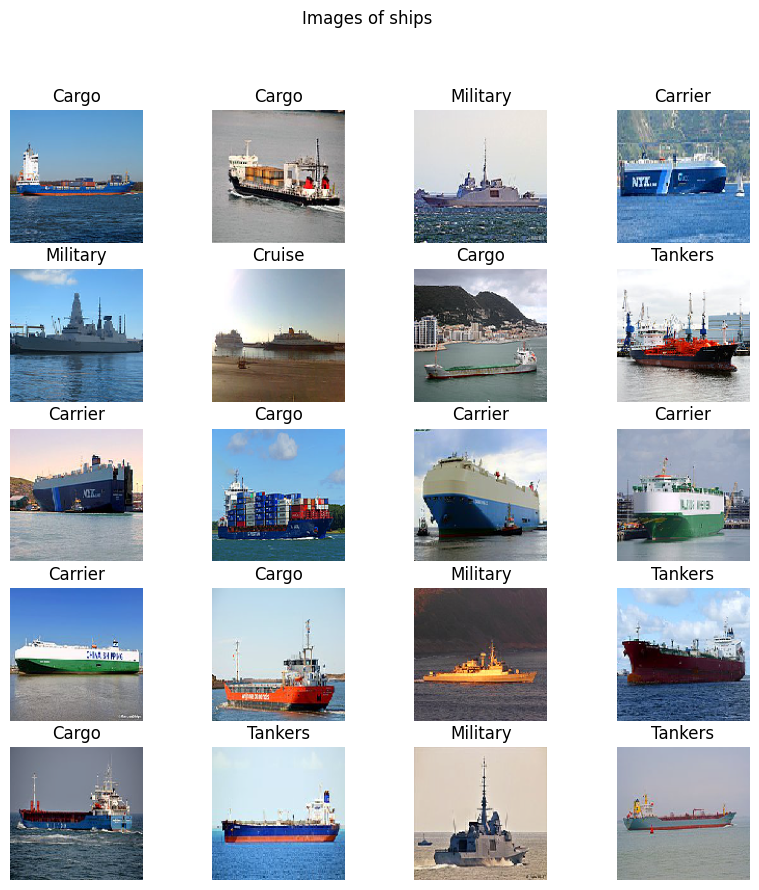

In [10]:
row = 5
col = 4
plt.figure(figsize=(10, 10))
plt.suptitle("Images of ships")
for i, image in enumerate(resized_images[:row*col], 1):
    plt.subplot(row, col, i)
    plt.imshow(image)
    plt.title(train["category"].map(train_categories)[i-1])
    plt.axis('off')
    plt.grid(False)
plt.show()

#### Data augmentation

In [11]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
])

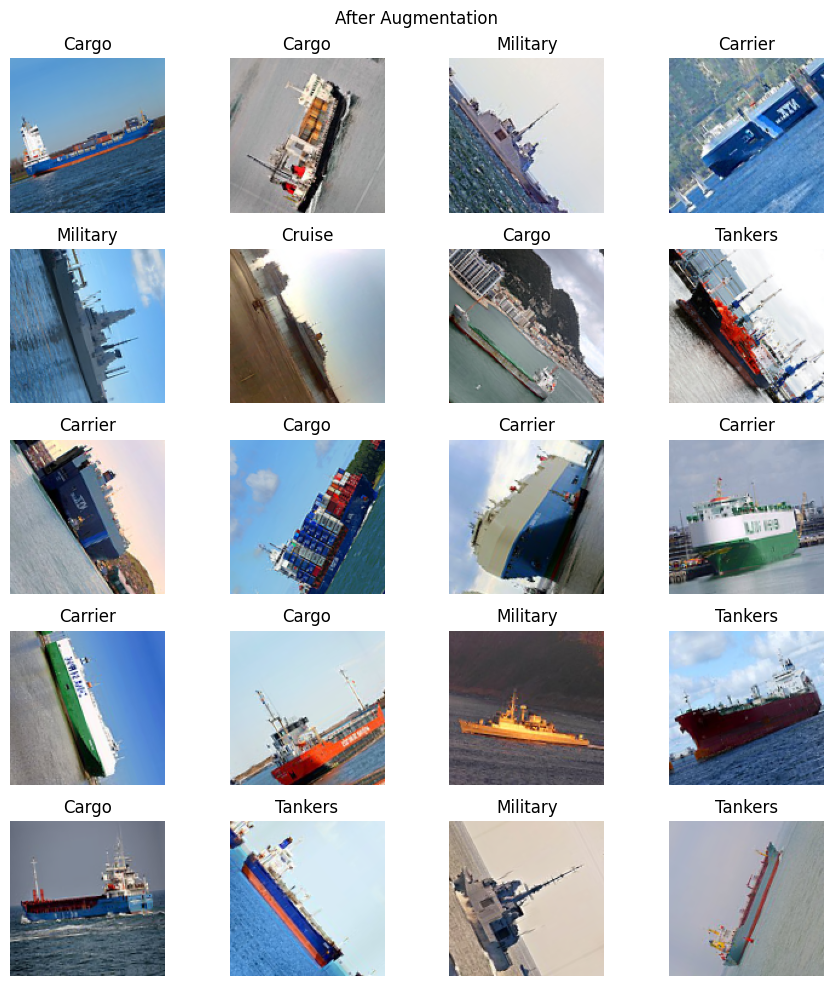

In [12]:
plt.figure(figsize=(10, 10))
plt.suptitle("After Augmentation")
augmented_image = data_augmentation(resized_images[:20])
for i, image in enumerate(resized_images[:row*col], 1):
    plt.subplot(row, col, i)
    plt.imshow(augmented_image[i-1])
    plt.title(train["category"].map(train_categories)[i-1])
    plt.axis('off')
    plt.grid(False)
    plt.tight_layout(pad=1)
plt.show()

In [25]:
values = train["category"] - 1
train_categories = {0 : 'Cargo',
1 : 'Military',
2 : 'Carrier',
3 : 'Cruise',
4 : 'Tankers'}

In [26]:
model = Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),
    data_augmentation,
    
    Conv2D(32, (3, 3), activation="relu"),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(2, 2),
    
    Conv2D(90, (3, 3), activation="relu"),
    MaxPooling2D(2, 2),
    
    Dropout(0.3),
    
    Flatten(),
    
    Dense(128, activation="sigmoid"),
    Dense(5, activation="softmax")
])

In [27]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [28]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 90)     │        51,930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 90)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 90)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 17640)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     2,258,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,015 (8.89 MB)

 Trainable params: 2,330,015 (8.89 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
dataset = tf.data.Dataset.from_tensor_slices((resized_images, values)).shuffle(1000).batch(batch_size=32).prefetch(tf.data.AUTOTUNE)

In [30]:
def divide(dataset):
    train_val = 0.8
    test_val = 0.1
    train_size = int(train_val * len(dataset))
    test_size = int(test_val * len(dataset))
    train_dataset = dataset.take(train_size)
    test_dataset = dataset.skip(train_size).take(test_size)
    val_dataset = dataset.skip(train_size + test_size)
    return train_dataset,  test_dataset, val_dataset

In [31]:
data_train, data_test, data_val = divide(dataset)

#### Adding callbacks

In [32]:
logger = CSVLogger("full_logger.csv", append=False)
lrPlateau = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.0,
)
checkpoint = ModelCheckpoint("full.model.keras",
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True)
# early = EarlyStopping(
#     monitor='val_loss',
#     min_delta=0,
#     patience=5,
#     verbose=1,
#     mode='auto',
#     baseline=None,
#     restore_best_weights=False,
#     start_from_epoch=60
# )

callbacks = [logger, lrPlateau, checkpoint]


In [33]:
history = model.fit(data_train, epochs=100, validation_data=data_val, callbacks=callbacks, verbose=1)

Epoch 1/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 52s 162ms/step - accuracy: 0.3968 - loss: 1.4092 - val_accuracy: 0.3224 - val_loss: 2.5109 - learning_rate: 0.0010
Epoch 2/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 34s 128ms/step - accuracy: 0.4792 - loss: 1.2649 - val_accuracy: 0.3600 - val_loss: 1.9732 - learning_rate: 0.0010
Epoch 3/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 33s 123ms/step - accuracy: 0.5310 - loss: 1.1409 - val_accuracy: 0.3863 - val_loss: 1.9924 - learning_rate: 0.0010
Epoch 4/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 33s 124ms/step - accuracy: 0.5801 - loss: 1.0029 - val_accuracy: 0.3825 - val_loss: 1.7400 - learning_rate: 0.0010
Epoch 5/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 32s 122ms/step - accuracy: 0.5900 - loss: 0.9770 - val_accuracy: 0.4164 - val_loss: 1.6867 - learning_rate: 0.0010
Epoch 6/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 32s 121ms/step - accuracy: 0.6265 - loss: 0.9050 - val_accuracy: 0.4398 - val_loss: 1.4949 - learning_rate: 0.0010
Epoch 7/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 32s 121ms/step - accura

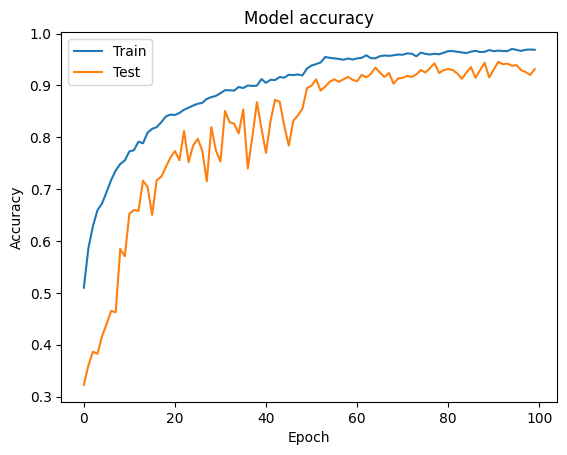

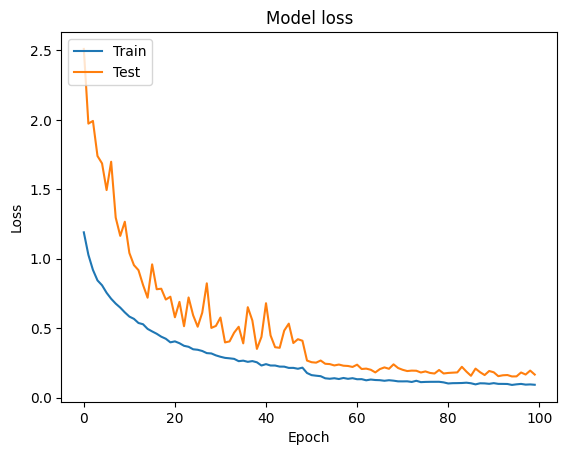

In [34]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


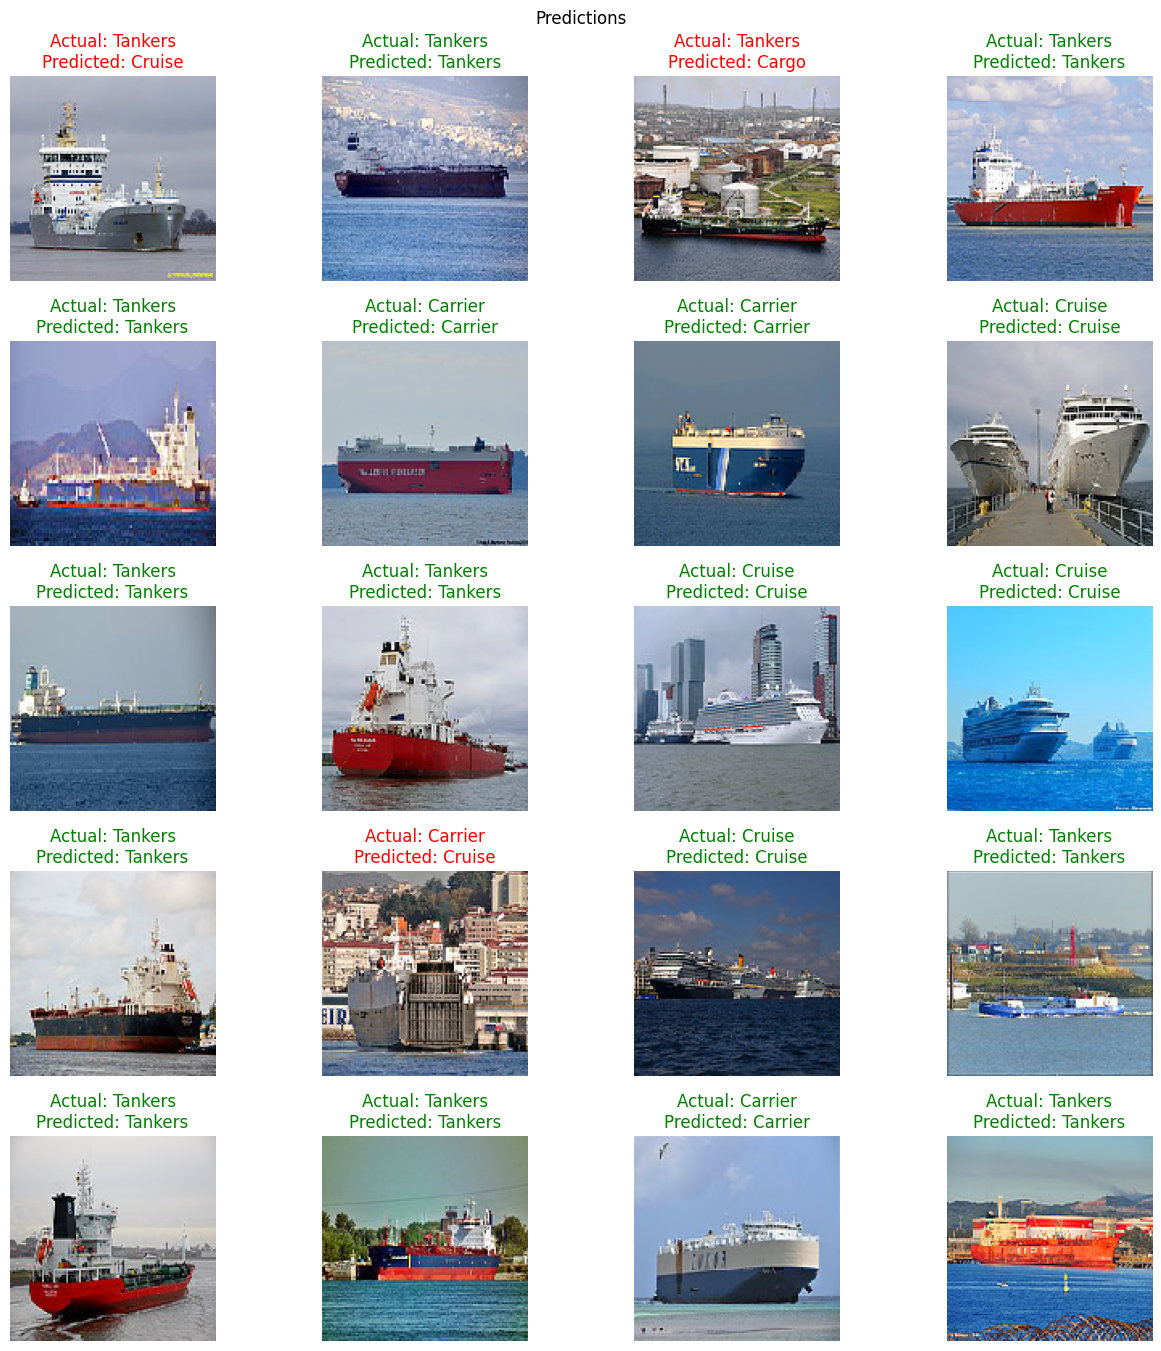

In [35]:
plt.figure(figsize=(14, 14))
plt.suptitle("Predictions")

for i in data_test:
    image = i[0]
    label = i[1]

for i in range(1, 21):
    plt.subplot(row, col, i)
    plt.imshow(image[i-1])
    prediction = np.argmax(model.predict(tf.expand_dims(image[i-1], 0)))
    prediction = train_categories[prediction]
    actual = train_categories[label[i-1].numpy()]
    if prediction == actual:
        color = "green"
    else:
        color = "red"
    plt.title(f"Actual: {actual}\nPredicted: {prediction}", color=color)
    plt.tight_layout(pad=1.2)
    
    plt.grid(False)
    plt.axis("Off")
plt.show()

In [36]:
model.save("full_ship_model.keras")